# Data analysis for $\mu = 0.4$ 21file(06.000exp) order Name

The code reads in the data from the associated .xlsx files, which contains information on:
- the number of photons produced
- the number of individual events
- the estimated probability distribution (after post-selecting on click events)

The code then runs the finite analysis SDP with a confidence parameter $\epsilon$, in order to find out how much randomness can be certified.

In [1]:
tic

S = dir('(*.xlsx');
nfiles = length(S);

epsi = 1E-9;
xs = 5;

Pg = zeros(1,nfiles);
Hmin = zeros(1,nfiles);

for i = 1:nfiles
    S(i).name;
    data = xlsread(S(i).name);
    
    nax = data(1:5,1:10)';
    mu = str2num(regexp(S(i).name,'(?<=_mi).+(?=_.xlsx$)','once','match'));
    xiax = nax./(ones(10,1)*sum(nax,1));
    
    
    p0 = 0; % we assume postselection
    p1 = exp(-mu)*mu;
    p2 = exp(-mu)*mu^2/2;

    psum = p0 + p1 + p2;

    p0 = p0/psum;
    p1 = p1/psum;
    p2 = p2/psum;

    d = 15;
    kets = eye(d);
    omegax = zeros(d,d,5);

    omegax(:,:,1) = p0*kets(:,1)*kets(1,:) + p1*kets(:,2)*kets(2,:) + p2*kets(:,6)*kets(6,:);
    omegax(:,:,2) = p0*kets(:,1)*kets(1,:) + p1*kets(:,3)*kets(3,:) + p2*kets(:,7)*kets(7,:);
    omegax(:,:,3) = p0*kets(:,1)*kets(1,:) + p1*kets(:,4)*kets(4,:) + p2*kets(:,8)*kets(8,:);
    omegax(:,:,4) = p0*kets(:,1)*kets(1,:) + p1*kets(:,5)*kets(5,:) + p2*kets(:,9)*kets(9,:);

    chi = 1/2*(kets(:,2) - kets(:,3) + kets(:,4) + kets(:,5));
    chi2 = (kets(:,6) + kets(:,7) + kets(:,8) + kets(:,9) +2*kets(:,15)...
            -2*kets(:,14)+2*kets(:,13)-2*kets(:,12)+2*kets(:,11)-2*kets(:,10));
    chi2 = chi2/sqrt(trace(chi2*chi2'));

    omegax(:,:,5) = p0*kets(:,1)*kets(1,:) + p1*chi*chi' + p2*chi2*chi2';
    
    [oa,ma] = size(xiax);

    cvx_begin sdp quiet

        variable Nae(d,d,oa,oa) hermitian semidefinite
        variable qe(oa)
        variable Pax(oa,ma)
      
        maximise real(sumall(conj(repmat(omegax(:,:,xs),[1,1,oa,oa])).*Nae.*...
            permute(repmat(eye(oa),[1,1,d,d]),[3,4,1,2])))
    
        for a = 1:oa-1
            for x = 1:ma
                xiax(a,x) - sqrt(log(1/epsi)/2/sum(nax(:,x))) <= trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x))
                trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x)) <= xiax(a,x) + sqrt(log(1/epsi)/2/sum(nax(:,x))) 
            end
        end
    
    
        for e = 1:oa 
            sum(Nae(:,:,:,e),3) == qe(e)*eye(d)
        end
    
        sum(qe) == 1
    
    cvx_end

    Pg(i) = cvx_optval;
    Hmin(i) = -log2(cvx_optval);

end

Hmin

toc

Hmin =
  Columns 1 through 7
    1.1619    1.2202    1.0992    1.1387    1.1373    1.1597    1.1437
  Columns 8 through 14
    1.0856    1.1344    1.1486    1.0832    1.1307    1.1003    1.1119
  Columns 15 through 21
    1.1041    1.1230    1.1665    1.1895    1.1144    1.1402    1.1113
Elapsed time is 66.786093 seconds.


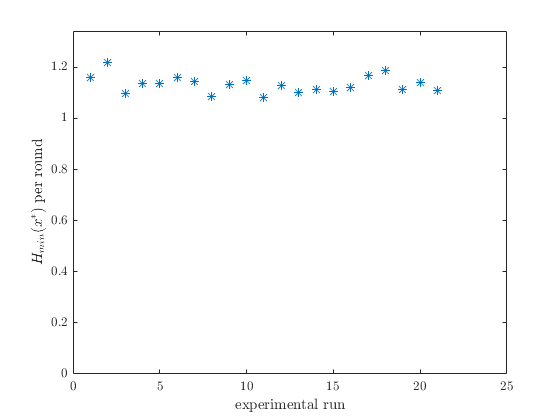

In [2]:
plot(Hmin,'*')
ylim([0 1.1*max(Hmin)])
xlabel('experimental run')
ylabel('$H_{min}(x^*)$ per round')

In [3]:
[min(Hmin) max(Hmin)]

ans =
    1.0832    1.2202
